In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from scipy import stats

In [7]:
df = pd.DataFrame(
    {"x": [1,2,3,4,5],
     "y": [3,7,5,11,14]}
)
df

,x,y
0,1,3
1,2,7
2,3,5
3,4,11
4,5,14


In [8]:
media_x = df["x"].mean()
media_y = df["y"].mean()
print(f"Media de x: {media_x}")
print(f"Media de y: {media_y}")

Media de x: 3.0
Media de y: 8.0


In [9]:
# Vamos calcular o coficiente angular (b1)
b1 = sum((df["x"] - media_x) * (df["y"] - media_y)) / sum((df["x"] - media_x) ** 2)
print(f"Coeficiente angular (b1): {b1}")

Coeficiente angular (b1): 2.6


In [10]:
# Agora vamos calcular o coeficiente linear (b0)
# a fórmula é: b0 = media_y - b1 * media_x
b0 = media_y - b1 * media_x
print(f"Coeficiente linear (b0): {round(b0, 2)}")

Coeficiente linear (b0): 0.2


In [11]:
# Ou seja nesta analise, identificamos que para cada unidade de x, y aumenta 0,2 unidades, 
# e que quando x é igual a zero, y é igual a 0,2. Assim, para x = 4, a previsão é que y seja aproximadamente 10,6.

# Métodos de Otimização para Regressão Linear

Para o modelo de regressão linear, existem alguns métodos de otimização importantes:

## Método dos Mínimos Quadrados

É o método mais comum para encontrar os coeficientes da regressão linear. Ele funciona minimizando a soma dos quadrados dos erros entre os pontos de dados e a reta de regressão.

## Método do Gradiente Descendente

É um algoritmo iterativo que ajusta os coeficientes da regressão linear para minimizar a função de custo. Este método é especialmente útil quando:

- Temos um grande conjunto de dados
- Queremos ajustar um modelo de regressão linear com múltiplas variáveis independentes

### Importar os dados

## Data prep

In [12]:
df_example = pd.read_csv("../data/housing.csv")
df_example.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
df_example.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.6 MB


In [14]:
# Aqui vamos  tratar esses valores nulos prrenchendo com a mediana da coluna.
df_example['total_bedrooms']=  df_example['total_bedrooms'].fillna(df_example['total_bedrooms'].median())

## Feature engineering

In [15]:
# Codificar ocean_proximity (categórica -> numérica)
label_encoder = LabelEncoder()
df_example['ocean_proximity'] = label_encoder.fit_transform(df_example['ocean_proximity'])

# Criar novas features
df_example['rooms_per_household'] = df_example['total_rooms'] / df_example['households']
df_example['bedrooms_per_room'] = df_example['total_bedrooms'] / df_example['total_rooms']
df_example['population_per_household'] = df_example['population'] / df_example['households']

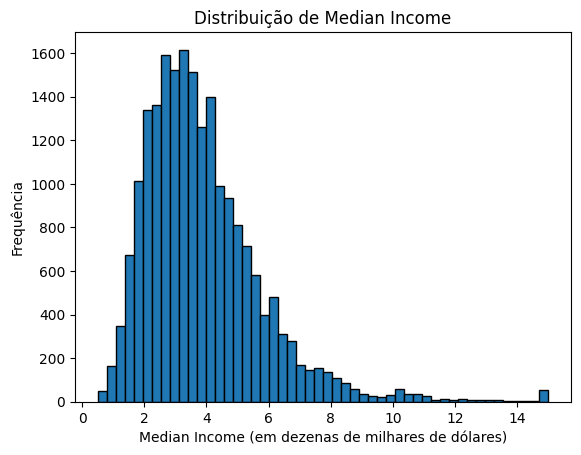

In [16]:
plt.hist(df_example['median_income'], bins=50, edgecolor='black')
plt.xlabel('Median Income (em dezenas de milhares de dólares)')
plt.ylabel('Frequência')
plt.title('Distribuição de Median Income')
plt.show()

### Teste de diferentes combinações de features

Vamos testar 6 combinações diferentes para encontrar qual conjunto de features produz o melhor R²:

In [17]:
# Vamos testar diferentes combinações de features para encontrar o melhor R²

# Preparar dados
y = df_example['median_house_value']

# Definir diferentes combinações de features
combinacoes = {
    'Teste 1 - Básico': ['median_income', 'total_rooms', 'housing_median_age'],
    'Teste 2 - Com ocean': ['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity'],
    'Teste 3 - Com engenharia': ['median_income', 'total_rooms', 'housing_median_age', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household'],
    'Teste 4 - Tudo': ['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household'],
    'Teste 5 - Geográfico': ['median_income', 'latitude', 'longitude', 'housing_median_age', 'ocean_proximity'],
    'Teste 6 - Completo': ['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'latitude', 'longitude'],
}

# Testar cada combinação
resultados = []
for nome, features in combinacoes.items():
    X = df_example[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model_test = LinearRegression()
    model_test.fit(X_train, y_train)
    
    y_pred = model_test.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    resultados.append({
        'Combinação': nome,
        'Features': len(features),
        'R²': r2,
        'RMSE': rmse
    })
    print(f"{nome}: R² = {r2:.4f}, RMSE = {rmse:.2f}")

# Criar dataframe com resultados
df_resultados = pd.DataFrame(resultados).sort_values('R²', ascending=False)
print("\n" + "="*60)
print("RANKING DE MELHORES MODELOS:")
print("="*60)
df_resultados

Teste 1 - Básico: R² = 0.4992, RMSE = 81013.45
Teste 2 - Com ocean: R² = 0.5064, RMSE = 80428.82
Teste 3 - Com engenharia: R² = 0.4166, RMSE = 87432.64
Teste 4 - Tudo: R² = 0.4241, RMSE = 86871.00
Teste 5 - Geográfico: R² = 0.5818, RMSE = 74029.69
Teste 6 - Completo: R² = 0.5322, RMSE = 78293.80

RANKING DE MELHORES MODELOS:


,Combinação,Features,R²,RMSE
4,Teste 5 - Geográfico,5,0.581780,74029.693967
5,Teste 6 - Completo,9,0.532213,78293.799378
1,Teste 2 - Com ocean,4,0.506353,80428.816704
0,Teste 1 - Básico,3,0.499150,81013.447402
3,Teste 4 - Tudo,7,0.424106,86871.001568
2,Teste 3 - Com engenharia,6,0.416635,87432.642557


### Visualização da comparação entre modelos

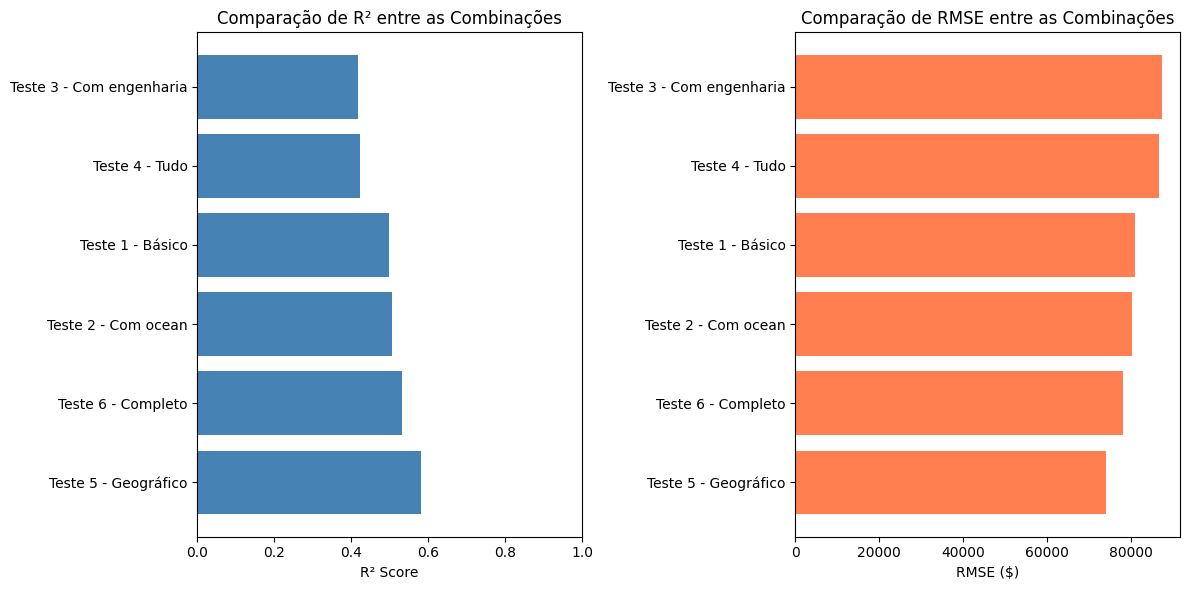


🏆 VENCEDOR: Teste 5 - Geográfico
   R² = 0.5818
   RMSE = $74,029.69


In [ ]:
# Visualizar comparação dos modelos
plt.figure(figsize=(12, 6))

# Gráfico de barras do R²
plt.subplot(1, 2, 1)
plt.barh(df_resultados['Combinação'], df_resultados['R²'], color='steelblue')
plt.xlabel('R² Score')
plt.title('Comparação de R² entre as Combinações')
plt.xlim(0, 1)

# Gráfico de RMSE
plt.subplot(1, 2, 2)
plt.barh(df_resultados['Combinação'], df_resultados['RMSE'], color='coral')
plt.xlabel('RMSE ($)')
plt.title('Comparação de RMSE entre as Combinações')

plt.tight_layout()
plt.show()

print(f"\n🏆 VENCEDOR: {df_resultados.iloc[0]['Combinação']}")
print(f"   R² = {df_resultados.iloc[0]['R²']:.4f}")
print(f"   RMSE = ${df_resultados.iloc[0]['RMSE']:,.2f}")

In [18]:
# Usar o melhor modelo (Teste 6 - Completo)
melhor_features = ['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity', 
                   'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 
                   'latitude', 'longitude']

df_model = df_example[melhor_features + ['median_house_value']]
print(f"✅ Modelo com {len(melhor_features)} features selecionadas")
df_model.head()

✅ Modelo com 9 features selecionadas


,median_income,total_rooms,housing_median_age,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,latitude,longitude,median_house_value
0,8.3252,880.0,41.0,3,6.984127,0.146591,2.555556,37.88,-122.23,452600.0
1,8.3014,7099.0,21.0,3,6.238137,0.155797,2.109842,37.86,-122.22,358500.0
2,7.2574,1467.0,52.0,3,8.288136,0.129516,2.802260,37.85,-122.24,352100.0
3,5.6431,1274.0,52.0,3,5.817352,0.184458,2.547945,37.85,-122.25,341300.0
4,3.8462,1627.0,52.0,3,6.281853,0.172096,2.181467,37.85,-122.25,342200.0


### Treinamento do modelo de Regressão Linear

In [19]:
# aqui vamos chamar no modelo da regressão linear e treinar o modelo com os dados selecionados
# PAra x  vamos colocar as variavies independentes e para y a variavel dependentem que seria a median_house_value
model = LinearRegression()

X = df_model.drop('median_house_value', axis=1)
y = df_model['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# aqui estamos treinando o modelo
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [20]:
print(f"Coeficiente linear (b0): {model.intercept_}, Coeficientes (b1, b2, ...): {model.coef_}")

Coeficiente linear (b0): -3638207.4287942504, Coeficientes (b1, b2, ...): [ 4.38362753e+04  3.80633135e+00  1.21265003e+03  1.22887908e+03
  3.58280493e+03  3.94392095e+05 -3.46912020e+02 -3.99096522e+04
 -4.13879743e+04]


In [21]:
# Agora que o modelo está treinado, podemos fazer previsões
# Exemplo: casa com características específicas
new_data = pd.DataFrame({
    'median_income': [8.0],
    'total_rooms': [3000],
    'housing_median_age': [15],
    'ocean_proximity': [0],  # <1H OCEAN
    'rooms_per_household': [6.0],
    'bedrooms_per_room': [0.2],
    'population_per_household': [3.0],
    'latitude': [37.5],
    'longitude': [-122.3]
})
prediction = model.predict(new_data)
print(f"Previsão do valor da casa: ${prediction[0]:,.2f}")

Previsão do valor da casa: $406,563.33


### Avaliação do modelo

In [22]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*60)
print("🎯 RESULTADO FINAL DO MELHOR MODELO")
print("="*60)
print(f"MAE (Mean Absolute Error):  ${mae:,.2f}")
print(f"RMSE (Root Mean Squared):   ${rmse:,.2f}")
print(f"R² (Coef. Determinação):    {r2:.4f} ({r2*100:.2f}%)")
print("="*60)
print(f"\n✅ O modelo explica {r2*100:.2f}% da variação dos preços!")
print(f"✅ Erro médio de ±${rmse:,.2f}")

🎯 RESULTADO FINAL DO MELHOR MODELO
MAE (Mean Absolute Error):  $54,169.71
RMSE (Root Mean Squared):   $78,293.80
R² (Coef. Determinação):    0.5322 (53.22%)

✅ O modelo explica 53.22% da variação dos preços!
✅ Erro médio de ±$78,293.80


### Análise de Resíduos

Os resíduos são a diferença entre os valores reais e os valores previstos. Analisar os resíduos ajuda a verificar se o modelo atende aos pressupostos da regressão linear:

1. **Distribuição Normal** dos resíduos
2. **Homocedasticidade** (variância constante)
3. **Independência** dos erros
4. **Média zero** dos resíduos

In [23]:
# Calcular resíduos
residuos = y_test - y_pred

print("Estatísticas dos Resíduos:")
print(f"Média dos resíduos: {residuos.mean():.2f} (deve ser próximo de 0)")
print(f"Desvio padrão: ${residuos.std():,.2f}")
print(f"Mínimo: ${residuos.min():,.2f}")
print(f"Máximo: ${residuos.max():,.2f}")

Estatísticas dos Resíduos:
Média dos resíduos: -1023.27 (deve ser próximo de 0)
Desvio padrão: $78,296.60
Mínimo: $-1,330,014.69
Máximo: $433,998.33


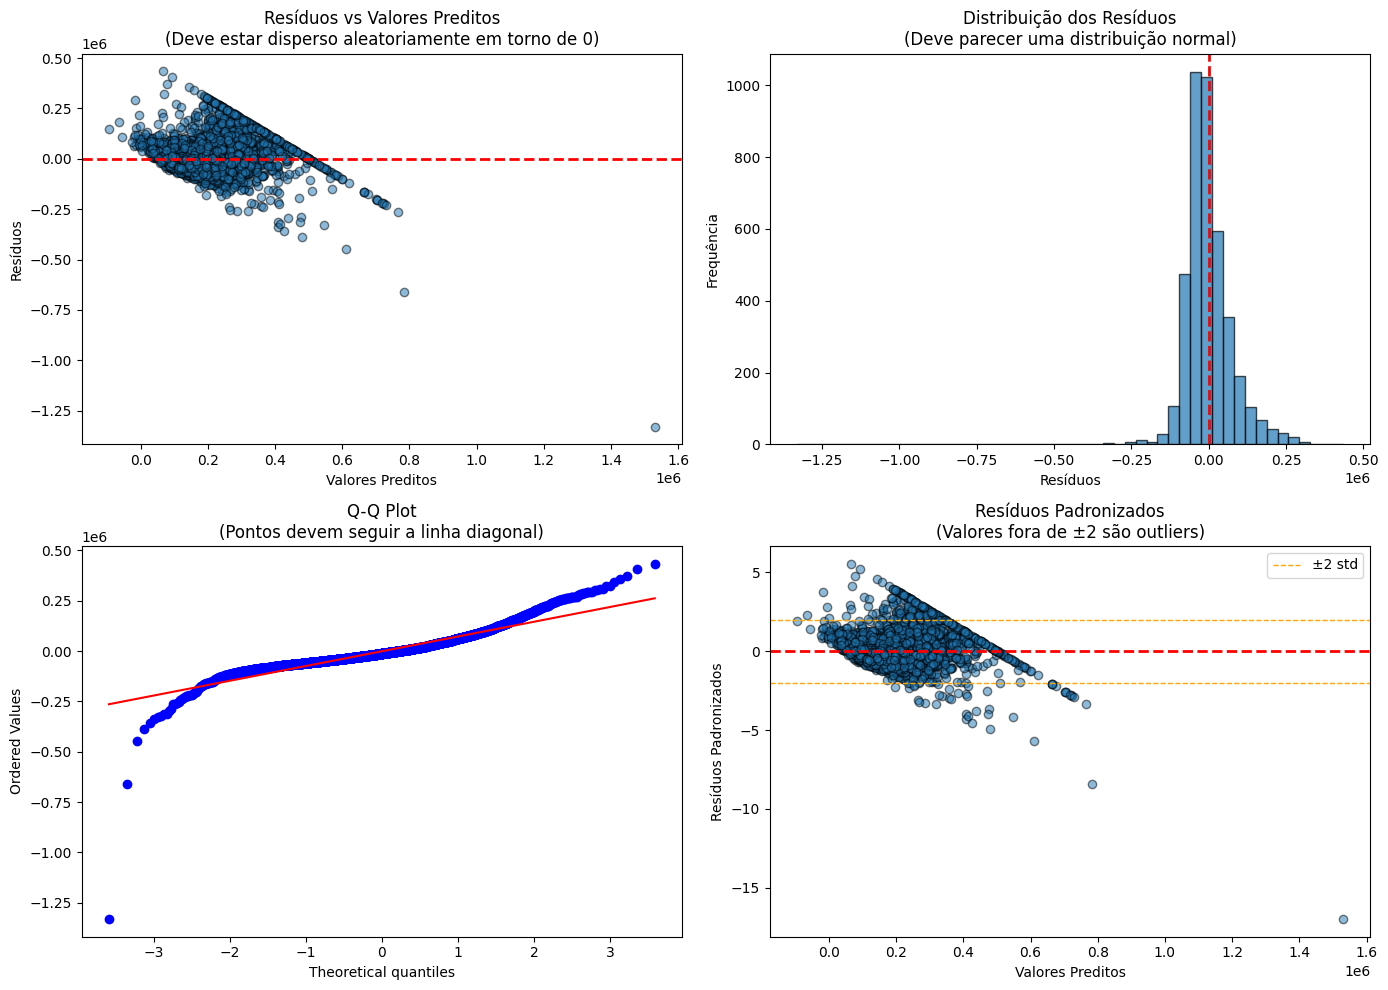

In [24]:
# Visualizações dos resíduos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Resíduos vs Valores Preditos
axes[0, 0].scatter(y_pred, residuos, alpha=0.5, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Valores Preditos')
axes[0, 0].set_ylabel('Resíduos')
axes[0, 0].set_title('Resíduos vs Valores Preditos\n(Deve estar disperso aleatoriamente em torno de 0)')

# 2. Histograma dos Resíduos
axes[0, 1].hist(residuos, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Resíduos')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição dos Resíduos\n(Deve parecer uma distribuição normal)')

# 3. Q-Q Plot (Normalidade)
from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot\n(Pontos devem seguir a linha diagonal)')

# 4. Resíduos Padronizados
residuos_padronizados = (residuos - residuos.mean()) / residuos.std()
axes[1, 1].scatter(y_pred, residuos_padronizados, alpha=0.5, edgecolors='k')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle='--', linewidth=1, label='±2 std')
axes[1, 1].axhline(y=-2, color='orange', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Valores Preditos')
axes[1, 1].set_ylabel('Resíduos Padronizados')
axes[1, 1].set_title('Resíduos Padronizados\n(Valores fora de ±2 são outliers)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [25]:
# Testar normalidade dos resíduos (Shapiro-Wilk)
from scipy.stats import shapiro

stat, p_value = shapiro(residuos.sample(min(5000, len(residuos))))  # Amostra para performance

print("="*60)
print("📊 TESTE DE NORMALIDADE (Shapiro-Wilk)")
print("="*60)
print(f"Estatística: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value > 0.05:
    print("✅ Resíduos seguem distribuição normal (p > 0.05)")
else:
    print("⚠️ Resíduos NÃO seguem distribuição normal (p < 0.05)")
    print("   Considere: transformações, GLM, ou modelos não-lineares")
print("="*60)

📊 TESTE DE NORMALIDADE (Shapiro-Wilk)
Estatística: 0.8778
P-value: 0.0000
⚠️ Resíduos NÃO seguem distribuição normal (p < 0.05)
   Considere: transformações, GLM, ou modelos não-lineares


### Interpretação da Análise de Resíduos

**O que procurar:**

1. **Resíduos vs Preditos**: 
   - ✅ BOM: Pontos dispersos aleatoriamente em torno de zero
   - ❌ RUIM: Padrões (curvas, funil) indicam problemas no modelo

2. **Histograma**: 
   - ✅ BOM: Formato de sino (distribuição normal)
   - ❌ RUIM: Assimetria forte ou múltiplos picos

3. **Q-Q Plot**: 
   - ✅ BOM: Pontos próximos à linha diagonal
   - ❌ RUIM: Pontos se afastam nas extremidades

4. **Teste de Shapiro-Wilk**:
   - ✅ p-value > 0.05 = Resíduos normais
   - ❌ p-value < 0.05 = Resíduos NÃO normais

**Se os resíduos não são normais ou há padrões:**
- Considere usar **GLM (Generalized Linear Model)**
- Teste **Random Forest** ou **XGBoost**
- Aplique **transformações** nos dados (log, sqrt)

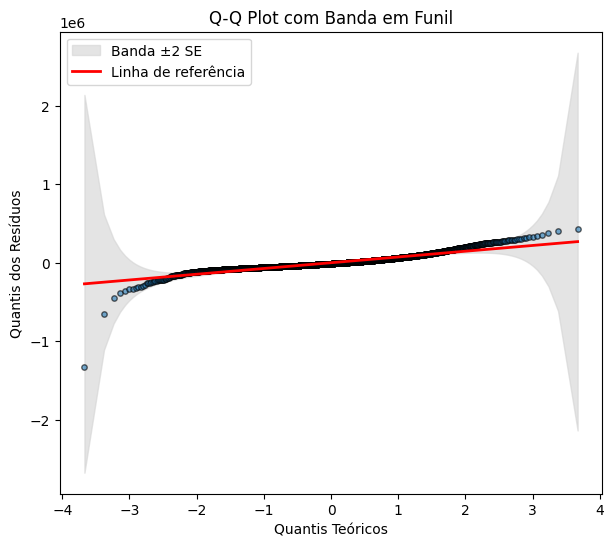

In [26]:
# Q-Q plot com bandas em "funil"
res = residuos.dropna().values
n = len(res)
res_sorted = np.sort(res)
theo_q = stats.norm.ppf((np.arange(1, n + 1) - 0.5) / n)

# Linha de referência
slope, intercept, *_ = stats.linregress(theo_q, res_sorted)
line = intercept + slope * theo_q

# Bandas aproximadas (funil)
se = (slope / stats.norm.pdf(theo_q)) * np.sqrt((0.5 * 0.5) / n)
upper = line + 2 * se
lower = line - 2 * se

plt.figure(figsize=(7, 6))
plt.fill_between(theo_q, lower, upper, color='lightgray', alpha=0.6, label='Banda ±2 SE')
plt.scatter(theo_q, res_sorted, s=15, alpha=0.6, edgecolors='k')
plt.plot(theo_q, line, color='red', lw=2, label='Linha de referência')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis dos Resíduos')
plt.title('Q-Q Plot com Banda em Funil')
plt.legend()
plt.show()